In [7]:
import notebook_functions
reload(notebook_functions)
from notebook_functions import *
import os, pandas as pd, cPickle as pickle
from nolearn.lasagne.visualize import plot_conv_activity, plot_conv_weights, plot_occlusion
from lasagne.layers import get_output, get_output_shape
import theano.tensor as T
import theano
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
val_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/test/"

In [9]:
def image_gen_from_dir_with_filenames(data_dir, batches, size):
    result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) 
                  for f in filenames if os.path.splitext(f)[1] == '.jpg']
    image_files = []
    filenames = []
    for file_path in result:
        image_files.append(read_img_file_PIL(file_path, size=input_volume_shape))
        filenames.append(os.path.basename(file_path))
        if len(image_files) == batches:
            X = np.asarray(image_files, dtype=np.float32)
            X = exposure.rescale_intensity(X, out_range=(-1,1))
            yield X, filenames
            image_files = []
            filenames = []
            
    # end result loop, yield any leftover image files
    X = np.asarray(image_files, dtype=np.float32)
    X = exposure.rescale_intensity(X, out_range=(-1,1))
    yield X, filenames

In [10]:
X, filenames = image_gen_from_dir_with_filenames(val_dir, 20, input_volume_shape).next()

In [11]:
dir_name = 'net.vgg.large.l2.5e3.orthog'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)

In [12]:
with open(model_file_name, 'rb') as reader:
    net = pickle.load(reader)

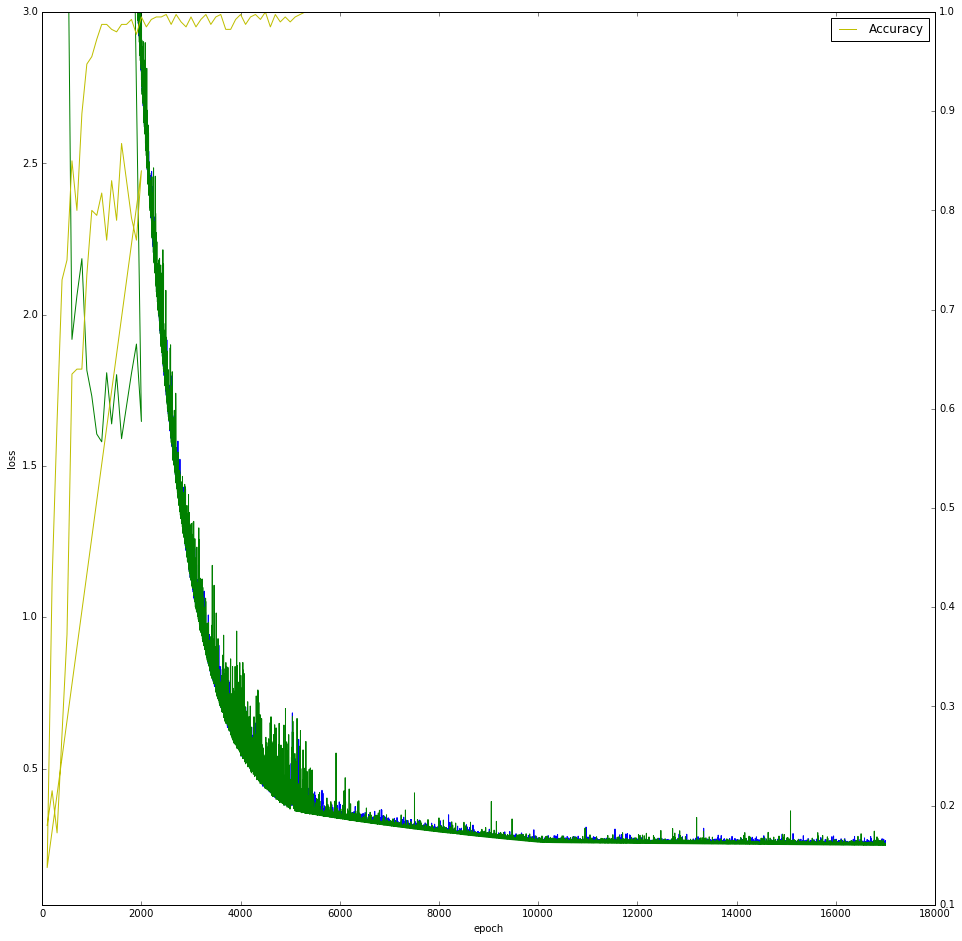

In [13]:
plot_validation_loss(net, validation_file_name,ylim=[0.05,3])

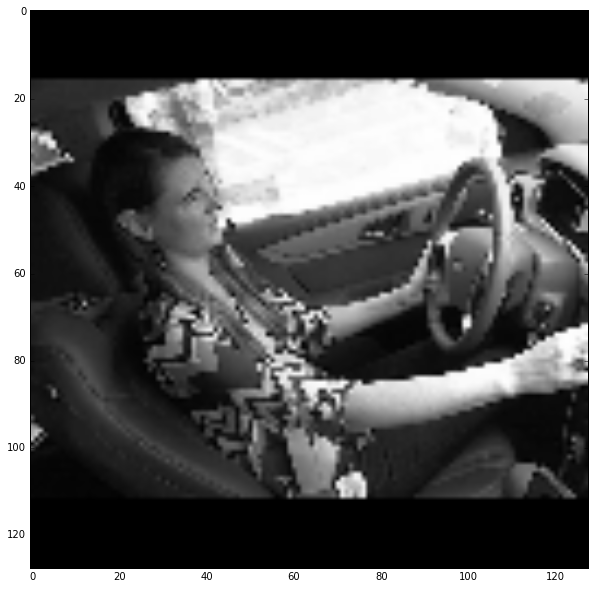

In [14]:
sample = X[0].reshape(1, 1, X[0].shape[0], X[0].shape[1])
plt.figure(figsize=(10,10))
plt.imshow(X[0], cmap='gray')
plt.show()

Original layer shape: (32, 128, 128)
Last shape: (6, 129, 6, 129)
Visualization shape (774, 774):
Prediction 5. [[  1.97877293e-04   3.00772558e-06   6.95704890e-04   5.29070792e-04
    2.98269715e-05   9.97152328e-01   3.22833075e-04   7.35956593e-04
    1.34863920e-04   1.98442242e-04]].


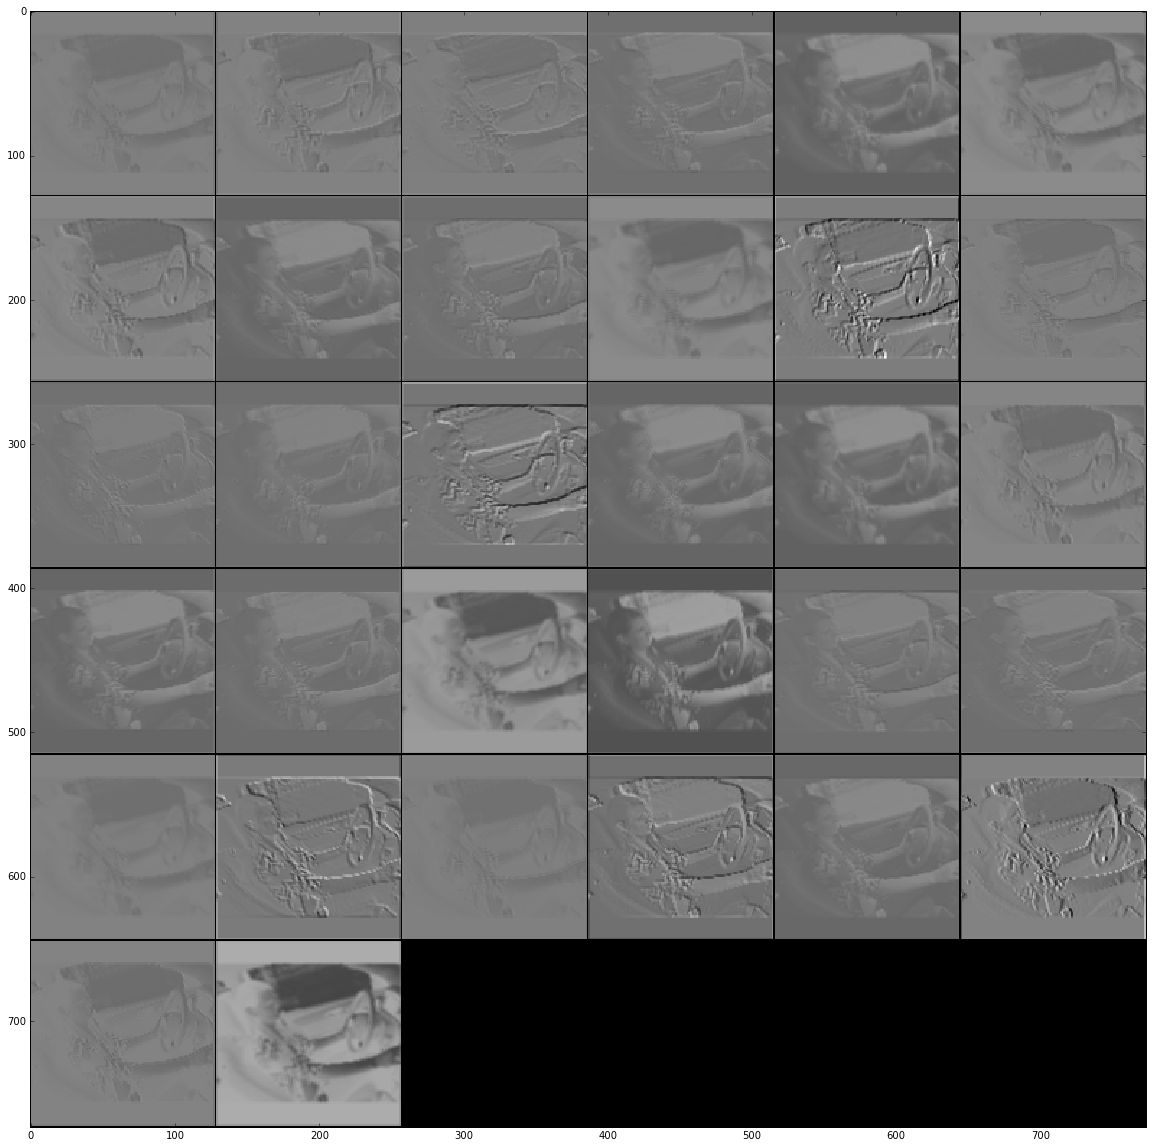

In [15]:
xs = T.tensor4('xs').astype(theano.config.floatX)
get_activity = theano.function([xs], get_output(net.layers_[1], xs))
sample = np.float32(X[0].reshape((1,1,128,128)))
activity = get_activity(sample)
activityS = activity.shape
vis_square(activity.reshape((activityS[1], activityS[2], activityS[3])))
probs = net.predict_proba(sample)
pred = np.argmax(probs)
print("Prediction {}. {}.".format(pred, probs))
plt.show()

# Evaluation Proper

In [16]:
load_best_weights(best_weights_file_name, net)

Loaded parameters to layer 'conv2ddnn1' (shape 32x1x3x3).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'conv2ddnn4' (shape 32x32x3x3).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'conv2ddnn8' (shape 64x32x3x3).
Loaded parameters to layer 'batchnorm9' (shape 64).
Loaded parameters to layer 'batchnorm9' (shape 64).
Loaded parameters to layer 'batchnorm9' (shape 64).
Loaded parameters to layer 'batchnorm9' (shape 64).
Loaded parameters to layer 'conv2ddnn11' (shape 64x64x3x3).
Loaded parameters to layer 'batchnorm12' (shape 64).
Loaded parameters to layer 'batchnorm12' (shape 64).
Loaded parameters to layer 'batchn

In [17]:
image_gen = image_gen_from_dir_with_filenames(val_dir, 40, input_volume_shape)
threaded_gen = threaded_generator(image_gen, num_cached=40)

all_probs = []
all_file_names = []
for X, file_names in threaded_gen:
    all_probs.extend(net.predict_proba(X.reshape(-1, 1, input_volume_shape[0], input_volume_shape[1])))
    all_file_names.extend(file_names)

In [18]:
df = pd.DataFrame(np.asarray(all_probs), 
                  index = all_file_names, columns=["c0","c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
df.index.name = 'img'
df.shape

(79726, 10)

In [19]:
df.to_csv("preds.l25e3.orthog.csv")

In [21]:
!head preds.l25e3.orthog.csv

img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img_73540.jpg,0.00019787781639,3.00772967421e-06,0.000695705821272,0.000529071490746,2.98270897474e-05,0.997152328491,0.000322833715472,0.000735958048608,0.000134864269057,0.000198442634428
img_9672.jpg,1.3444504475e-05,0.000207408127608,0.999215722084,0.000155084038852,7.43941291148e-06,6.48812274449e-05,0.000126922735944,3.27132147504e-05,0.000105603838165,7.07012513885e-05
img_49295.jpg,0.00198755203746,9.75668153842e-05,0.000195441112737,0.00283673894592,0.989526152611,0.000371196802007,0.00150210596621,0.000127066872665,0.00109382357914,0.00226231105626
img_91517.jpg,0.000256733881542,7.70706151343e-07,8.78075807123e-05,0.00019033884746,1.27230687212e-05,0.998990476131,6.80337616359e-05,0.0001665186428,3.75280396838e-05,0.00018903054297
img_51925.jpg,0.823394238949,0.0162333901972,0.00341076380573,0.00489587849006,0.0104794008657,0.00920839607716,0.00175179680809,0.000598668353632,0.0204597171396,0.109567888081
img_87962.jpg,3.03615456687e-06,0.00